This code is originally from https://github.com/yjucho1/anoGAN

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, UpSampling2D, Conv2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm

def generator_model():
    generator = Sequential()
    generator.add(Dense(128*32*32, input_dim=100, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((32, 32, 128)))
    generator.add(UpSampling2D(size=(2, 2)))
    generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
    generator.add(LeakyReLU(0.2))
    generator.add(UpSampling2D(size=(2, 2)))
    generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    return generator


def discriminator_model():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(128,128, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    return discriminator


def generator_containing_discriminator(g, d):
    d.trainable = False
    ganInput = Input(shape=(100,))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

def train(BATCH_SIZE, X_train):
    d = discriminator_model()
    print("#### discriminator ######")
    d.summary()
    g = generator_model()
    print("#### generator ######")
    g.summary()
    d_on_g = generator_containing_discriminator(g, d)
    d.trainable = True
    for epoch in tqdm(range(epochs), leave=False):
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, 100))
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
            d_loss = d.train_on_batch(X, y)
            noise = np.random.uniform(0, 1, (BATCH_SIZE, 100))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * BATCH_SIZE))
            d.trainable = True
        g.save_weights('assets/generator', True)
        d.save_weights('assets/discriminator', True)
    return d, g


def generate(BATCH_SIZE):
    g = generator_model()
    g.load_weights('assets/generator')
    noise = np.random.uniform(0, 1, (BATCH_SIZE, 100))
    generated_images = g.predict(noise)
    return generated_images

def sum_of_residual(y_true, y_pred):
    return tf.reduce_sum(abs(y_true - y_pred))

def feature_extractor():
    d = discriminator_model()
    d.load_weights('assets/discriminator') 
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-5].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='adam')
    return intermidiate_model

def anomaly_detector():
    g = generator_model()
    g.load_weights('assets/generator')
    g.trainable = False
    intermidiate_model = feature_extractor()
    intermidiate_model.trainable = False
    
    aInput = Input(shape=(100,))
    gInput = Dense((100))(aInput)
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.9, 0.1], optimizer='adam')
    return model

def compute_anomaly_score(model, x):    
    z = np.random.uniform(0, 1, size=(1, 100))
    intermidiate_model = feature_extractor()
    d_x = intermidiate_model.predict(x)
    loss = model.fit(z, [x, d_x], epochs=500, verbose=0)
    similar_data, _ = model.predict(z)
    return loss.history['loss'][-1], similar_data


In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('/content/anogan (3).py','wb').write(src)
import anogan

Saving anogan.py to anogan (4).py


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tqdm import tqdm
# import anogan
import glob
from PIL import Image
import PIL 
# from skimage import io
import cv2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd "/content/drive/My Drive/AUTproject"

In [ ]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [ ]:
Path_train1= glob.glob("/content/drive/My Drive/AUTproject/data/train/*.jpg")
Path_train2= glob.glob("/content/drive/My Drive/AUTproject/data/train/*.PNG")
Path_test= glob.glob("/content/drive/My Drive/AUTproject/data/test/*.jpg")
Path_test1= glob.glob("/content/drive/My Drive/AUTproject/data/test1/*.jpg")
X_train=[]
X_test=[]
size=(128,128)
for i in range(len(Path_train1)):
    img= Image.open(Path_train1[i])
    img= img.resize(size)
    img=np.array(img)
    img=rgb2gray(img)
    X_train.append(img)
    
for i in range(len(Path_train2)):
    img= Image.open(Path_train2[i])
    img= img.resize(size)
    img=np.array(img)
    img=rgb2gray(img)
    X_train.append(img)
    
for i in range(len(Path_test)):
    img= Image.open(Path_test[i])
    img= img.resize(size)
    img=np.array(img).astype("uint8")
    img=rgb2gray(img)
    X_test.append(img)

for i in range(len(Path_test1)):

  img= Image.open(Path_test1[i])
  img= img.resize(size)
  img=np.array(img).astype("uint8")
  
  # img=rgb2gray(img)
  X_test.append(img)
  


In [ ]:
X_test=[]
for i in range(len(Path_test)):
  img=cv2.imread(Path_test[i], cv2.IMREAD_GRAYSCALE)
  img=cv2.resize(img, size)

  X_test.append(img)


for i in range(len(Path_test1)):
  img=cv2.imread(Path_test1[i], cv2.IMREAD_GRAYSCALE)
  img=cv2.resize(img, size)

  X_test.append(img)



In [ ]:
X_test

[array([[193, 140, 142, ..., 155, 156, 157],
        [205, 137, 139, ..., 157, 156, 156],
        [218, 135, 142, ..., 158, 156, 156],
        ...,
        [233, 232, 232, ...,  86,  89,  90],
        [232, 232, 233, ...,  86,  91,  93],
        [233, 232, 232, ...,  91,  96,  97]], dtype=uint8),
 array([[ 57,  59,  62, ...,  44,  42,  41],
        [ 58,  59,  61, ...,  42,  41,  45],
        [ 57,  58,  59, ...,  41,  40,  44],
        ...,
        [103, 103, 103, ...,  58,  58,  58],
        [103, 103, 103, ...,  60,  58,  56],
        [ 99,  97,  96, ...,  63,  60,  59]], dtype=uint8),
 array([[ 94,  85,  82, ...,  56,  56,  58],
        [ 85,  76,  74, ...,  59,  58,  59],
        [ 85,  77,  76, ...,  56,  57,  59],
        ...,
        [151, 151, 148, ..., 101,  98, 100],
        [152, 151, 148, ..., 102, 103, 103],
        [151, 150, 148, ..., 103, 104, 104]], dtype=uint8),
 array([[213, 216, 222, ..., 215, 220, 198],
        [205, 209, 217, ..., 217, 218, 195],
        [199, 20

In [ ]:
X_train=np.array(X_train).astype(np.float32)/255.

X_train = X_train.reshape(len(X_train), 128,128, 1)


In [ ]:
print(X_train.shape)


(198, 128, 128, 1)


In [ ]:

# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train = X_train.astype(np.float32)/255.
# X_train = X_train.reshape(60000, 28, 28, 1)
# print(type(X_train))
epochs=2500
Model_d, Model_g = train(64, X_train)

  0%|          | 0/2500 [00:00<?, ?it/s]

#### discriminator ######
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (

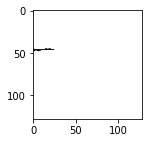

In [ ]:
## generate random image 

generated_img = generate(200)
plt.figure(figsize=(2, 2))
plt.imshow(generated_img[0].reshape(128, 128),cmap=plt.cm.gray)
plt.show()

In [ ]:
model.save_weigths("/content/drive/My Drive/AUTproject/weights/weigths.h5")

AttributeError: ignored

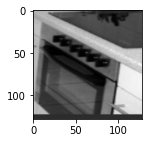

anomaly score : 12200.6376953125


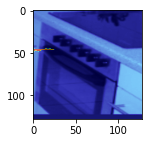

In [ ]:
## compute anomaly score - sample from test set
X_test=np.array(X_test)
X_test = X_test.astype(np.float32)/255.
X_test = X_test.reshape(-1, 128, 128, 1)
test_img = X_test[28]

model = anomaly_detector()
ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 128, 128, 1))

plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(128,128), cmap=plt.cm.gray)
plt.show()
print("anomaly score : " + str(ano_score))
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(128,128), cmap=plt.cm.gray)
residual  = test_img.reshape(128,128) - similar_img.reshape(128, 128)
plt.imshow(residual, cmap='jet', alpha=.5)
plt.show()

In [ ]:
score=[]
for i in range(len(X_test)):
  model = anomaly_detector()
  X_test=np.array(X_test)
  X_test = X_test.astype(np.float32)
  ano_score, similar_img = compute_anomaly_score(model, X_test[i].reshape(1, 128, 128, 1)) 
  score.append(ano_score)

In [ ]:
len(score)

17

In [ ]:
def normalizedata(s):
  s=np.array(s)
  s_new= np.empty((len(s),1))
  s_max= np.max(s)
  s_min=np.min(s)
  for i in range(len(s)):
    s_new[i]= s[i]-s_min/(s_max-s_min)

  return s_new
    

In [ ]:
#score=normalizedata(score)
score_max= np.max(score)
score_min=np.min(score)
score=(score-score_min)/(score_max-score_min)

In [ ]:
label1=list(np.ones((16,1)))
label0=list(np.zeros((len(score)-16,1)))
label=label1+label0
score


array([0.68179604, 0.44722763, 0.56575251, 1.        , 0.72067104,
       0.48584527, 0.45123248, 0.73245751, 0.8444319 , 0.40336098,
       0.53156296, 0.40182148, 0.27390801, 0.47487771, 0.46307052,
       0.63499868, 0.25821877, 0.46307622, 0.1845537 , 0.33793127,
       0.05238987, 0.34177454, 0.39122624, 0.22434546, 0.47421149,
       0.        , 0.43354508, 0.20515083, 0.29310032])

In [ ]:
len(score)

17

In [ ]:
len(label)

17

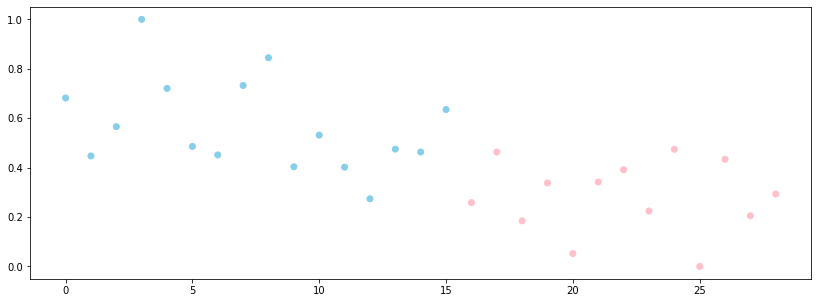

In [ ]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(label)), score, c=['skyblue' if x == 1 else 'pink' for x in label])

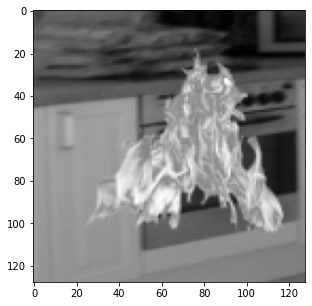

In [ ]:
plt.imshow(X_test[2].reshape(128,128), cmap=plt.cm.gray)
plt.show()

In [ ]:
label[20]

array([0.])

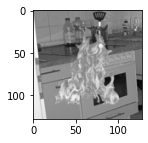

anomaly score : 14035.3154296875


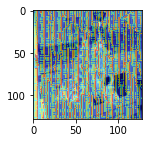

In [ ]:
## compute anomaly score - sample from strange image

# test_img = plt.imread('assets/test_img.png')
test_img =X_test[0]

model = anomaly_detector()
ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 128, 128, 1))

plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(128,128), cmap=plt.cm.gray)
plt.show()
print("anomaly score : " + str(ano_score))
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(128,128), cmap=plt.cm.gray)
residual  = test_img.reshape(128,128) - similar_img.reshape(128, 128)
plt.imshow(residual, cmap='jet', alpha=.5)
plt.show()
